In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Steps

1. Sep/Oct - 2022 data
(Since 2022 is missing, 2021 is used)
2. Three ISPs - CenturyLink, Comcast, Verizon
3. Get speed tier using `unit_profile.csv`
4. For each day, each unit_id, each speed tier - median RTT (Upload)
5. Line plot of latency - Upload and Download
6. Table - unique unit ids per ISP

In [2]:
speed_tier_dict = {
    'download': {
        'Comcast': [50, 100, 200, 400, 800],
        'CenturyLink': [1.5, 3.0, 10.0, 20, 25, 40, 80, 100], 
        'Verizon': [75, 100, 200]
    },
    'upload': {
        'Comcast': [ 5, 10, 15, 35],
        'CenturyLink': [0.5, 0.75, 0.768, 0.896, 1, 1.5, 2, 5, 10], 
        'Verizon': [75, 100, 200 ]
    }
}


In [3]:
def process_data(data, unit_profile, excluded_units):
    data = data.join(unit_profile, how='left', on='unit_id')
    data = data.filter(pl.col('isp').is_in(['Comcast', 'Verizon', 'CenturyLink']))

    exclude_units_list = excluded_units["unit_id"].unique().to_list()
    data = data.filter(~pl.col("unit_id").is_in(exclude_units_list))

    # Convert the dtime column to a datetime type
    data = data.with_columns(
        pl.col("dtime").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S").alias("dtime")
    )

    # Extract the year and month from the dtime column
    data = data.with_columns([
        pl.col("dtime").dt.year().alias("year"),
        pl.col("dtime").dt.month().alias("month"),
        pl.col("dtime").dt.day().alias("date")
    ])

    return data

In [4]:
def aggregate_data(data, direction):
    #data = data.with_columns(pl.col(direction).cast('Float64').alias(direction))
    aggregated = data.group_by(["isp", direction, "month", "date"]).agg([
            pl.col("rtt_avg").median().alias("median_latency"),
            # pl.col("rtt_max").median().alias("median_max_latency"),
            # pl.col("rtt_min").median().alias("median_min_latency"),
            # pl.col("technology").last().alias("technology"),
        ])
    
    aggregated = aggregated.with_columns(
        pl.col('median_latency')/pl.lit(1000).alias("median_latency")
        )
    
    aggregated = aggregated.with_columns(
            pl.concat_str([
                pl.lit("2021").cast(pl.Utf8),
                pl.col("month").cast(pl.Utf8),
                pl.col("date").cast(pl.Utf8)
            ], separator="-")
            .str.strptime(pl.Datetime, format="%Y-%m-%d")
            .dt.replace_time_zone("UTC")
            .alias("dtime")
        ).drop( "month", "date")

    return aggregated

In [5]:
def print_table(data, speed_tier_dict, direction: str):

    print(direction.capitalize())
    print('-------------------------------------')

    table_df = data.group_by(["isp", direction]).agg(pl.col("unit_id").n_unique())

    for isp in speed_tier_dict[direction].keys():
        temp = table_df.filter(pl.col("isp") == isp)
        temp = temp.filter(pl.col(direction).is_in(speed_tier_dict[direction][isp]))
        temp = temp.sort(by=direction)
        print(temp.to_pandas().to_markdown())
        print('\n')

In [ ]:
def plot_latency_by_isp(df: pl.DataFrame, speed_tier_dict: dict, direction: str):

    isp_speed_tiers = speed_tier_dict[direction]
 
    num_isps = len(isp_speed_tiers)
    fig, axs = plt.subplots(num_isps, 1, figsize=(12, 4*num_isps), sharex=True)
    
    # Ensure axs is iterable (in case there is only one ISP)
    if num_isps == 1:
        axs = [axs]
    
    # Use a colormap for consistent coloring across speed tiers
    cmap = plt.get_cmap("tab10")
    
    for ax, (isp, speed_tiers) in zip(axs, isp_speed_tiers.items()):
        # Filter data for the current ISP
        isp_df = df.filter(pl.col("isp") == isp)
        if isp_df.is_empty():
            print(f"No data available for ISP: {isp}")
            continue
        
        # Further filter the DataFrame to only include rows with the specified speed tiers
        isp_df = isp_df.filter(pl.col("download").is_in(speed_tiers))
        
        # Get unique available speed tiers in the filtered data (sorted)
        available_tiers = sorted(isp_df["download"].unique().to_list())
        
        for idx, tier in enumerate(available_tiers):
            # Filter for the current speed tier and sort by datetime
            subset = isp_df.filter(pl.col("download") == tier).sort("dtime")
            times = subset["dtime"].to_list()
            latencies = subset["median_latency"].to_list()
            
            ax.plot(times, latencies, label=f"Speed Tier: {tier}", color=cmap(idx % 10))
        
        # Format the subplot
        ax.set_title(f"Median Latency over Time for ISP: {isp}")
        ax.set_xlabel("Date Time")
        ax.set_ylabel("Median Latency")
        ax.legend(title="Download Speed Tier")
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    plt.tight_layout()
    plt.show()


def plot_latency_for_isp(df: pl.DataFrame, isp: str, speed_tier_dict: dict, direction: str):

    speed_tiers = speed_tier_dict[direction][isp]
    # Filter the DataFrame for the specified ISP
    isp_df = df.filter(pl.col("isp") == isp)
    
    if isp_df.is_empty():
        print(f"No data available for ISP: {isp}")
        return
    
    # Further filter for the specified speed tiers
    isp_df = isp_df.filter(pl.col(direction).is_in(speed_tiers))
    
    if isp_df.is_empty():
        print(f"No data available for ISP: {isp} with the specified speed tiers.")
        return

    # Get unique available speed tiers in the filtered data (sorted)
    available_tiers = sorted(isp_df[direction].unique().to_list())
    
    plt.figure(figsize=(12, 6))
    cmap = plt.get_cmap("tab10")
    
    for idx, tier in enumerate(available_tiers):
        # Filter for the current speed tier and sort by datetime
        subset = isp_df.filter(pl.col(direction) == tier).sort("dtime")
        times = subset["dtime"].to_list()
        latencies = subset["median_latency"].to_list()
        
        plt.plot(times, latencies, label=f"Speed Tier: {tier}", color=cmap(idx % 10))
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()  # Rotate date labels for readability
    
    plt.xlabel("Date")
    plt.ylabel("Median Latency (ms)")
    plt.title(f"Median {direction.capitalize()} Idle Latency over Time for ISP: {isp}")
    plt.legend(title="Speed Tier")
    plt.grid(axis='both', alpha = 0.7, linestyle='--')
    plt.tight_layout()
    plt.show()


In [7]:
def plot_data(data, direction):
    isp = speed_tier_dict[direction].keys()
    for isp_name in isp:
        plot_latency_for_isp(data, isp_name, speed_tier_dict, direction)

In [8]:
sept_2021_data = pl.read_parquet('./data/2021/202109/curr_udplatency.parquet')
oct_2021_data = pl.read_parquet('./data/2021/202110/curr_udplatency.parquet')
idle_data = pl.concat([sept_2021_data, oct_2021_data])
idle_data = idle_data.rename({col: col.strip().lower().replace(' ', '_') for col in idle_data.columns})

unit_profile_2021 = pl.read_csv('./unit_profile_files/unit-profile-sept2021.csv', infer_schema_length=10000)
unit_profile_2021 = unit_profile_2021.rename({col: col.strip().lower().replace(' ', '_') for col in unit_profile_2021.columns})
excluded_units = pl.read_excel('./unit_profile_files/units-excluded-sept2021.xlsx', infer_schema_length=10000)
excluded_units = excluded_units.rename({col: col.strip().lower().replace(' ', '_') for col in excluded_units.columns})

In [9]:
idle_data = process_data(idle_data, unit_profile_2021, excluded_units)
idle_data.head()

unit_id,dtime,target,rtt_avg,rtt_min,rtt_max,rtt_std,successes,failures,isp,technology,state,census,timezone_offset,timezone_offset_dst,download,upload,whitebox_model,year,month,date
i64,datetime[μs],str,i64,i64,i64,i64,i64,i64,str,str,str,str,i64,i64,f64,f64,str,i32,i8,i8
422,2021-09-01 00:08:44,"""sp1-vm-seattle-us.samknows.com""",9631,3604,18370,1875,2325,0,"""Comcast""","""Cable""","""WA""","""West""",-8,-7,100.0,5.0,"""wnr3500l-high""",2021,9,1
422,2021-09-01 00:08:44,"""21-on-regional-seattle.samknow…",12588,6771,18753,2438,2325,0,"""Comcast""","""Cable""","""WA""","""West""",-8,-7,100.0,5.0,"""wnr3500l-high""",2021,9,1
422,2021-09-01 01:08:42,"""21-on-regional-seattle.samknow…",12411,6887,19692,2569,1859,0,"""Comcast""","""Cable""","""WA""","""West""",-8,-7,100.0,5.0,"""wnr3500l-high""",2021,9,1
422,2021-09-01 01:08:42,"""sp1-vm-seattle-us.samknows.com""",9771,4561,19656,2024,1859,0,"""Comcast""","""Cable""","""WA""","""West""",-8,-7,100.0,5.0,"""wnr3500l-high""",2021,9,1
422,2021-09-01 02:08:40,"""sp1-vm-seattle-us.samknows.com""",9626,3706,18579,1725,2213,0,"""Comcast""","""Cable""","""WA""","""West""",-8,-7,100.0,5.0,"""wnr3500l-high""",2021,9,1


In [10]:

agg_download_data = aggregate_data(idle_data, 'download')
agg_upload_data = aggregate_data(idle_data, 'upload')

In [11]:
print_table(idle_data, speed_tier_dict, 'download')
print_table(idle_data, speed_tier_dict, 'upload')

Download
-------------------------------------
|    | isp     |   download |   unit_id |
|---:|:--------|-----------:|----------:|
|  0 | Comcast |         50 |        66 |
|  1 | Comcast |        100 |        57 |
|  2 | Comcast |        200 |        72 |
|  3 | Comcast |        400 |        93 |
|  4 | Comcast |        800 |        62 |


|    | isp         |   download |   unit_id |
|---:|:------------|-----------:|----------:|
|  0 | CenturyLink |        1.5 |        61 |
|  1 | CenturyLink |        3   |        59 |
|  2 | CenturyLink |       10   |        95 |
|  3 | CenturyLink |       20   |        70 |
|  4 | CenturyLink |       25   |        55 |
|  5 | CenturyLink |       40   |        64 |
|  6 | CenturyLink |       80   |        70 |
|  7 | CenturyLink |      100   |        45 |


|    | isp     |   download |   unit_id |
|---:|:--------|-----------:|----------:|
|  0 | Verizon |         75 |        48 |
|  1 | Verizon |        100 |        52 |
|  2 | Verizon |        200

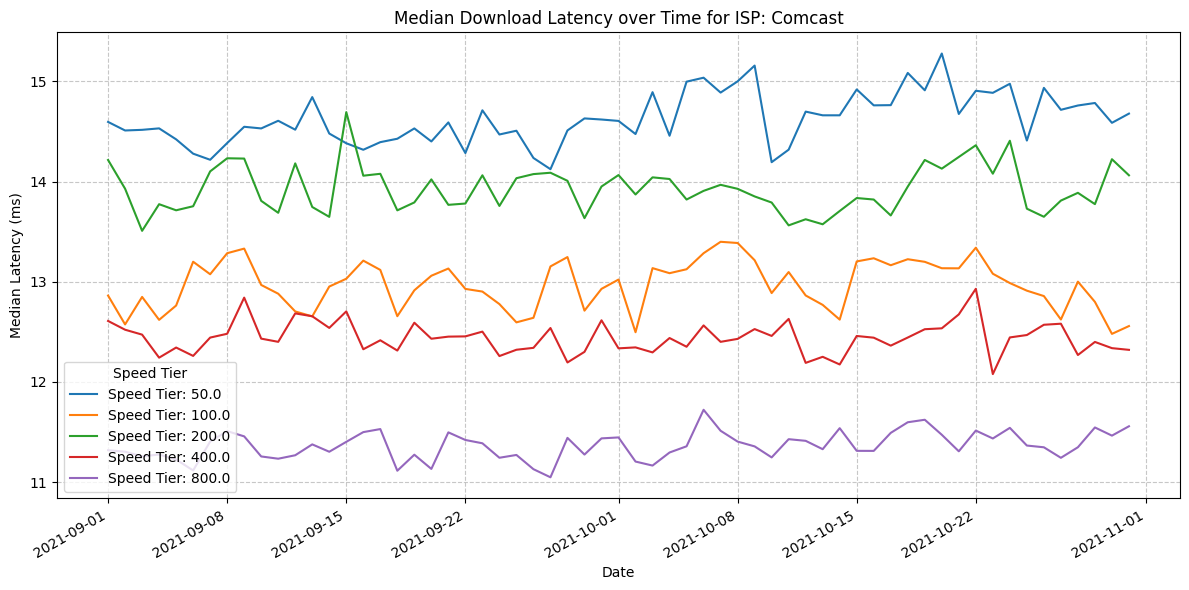

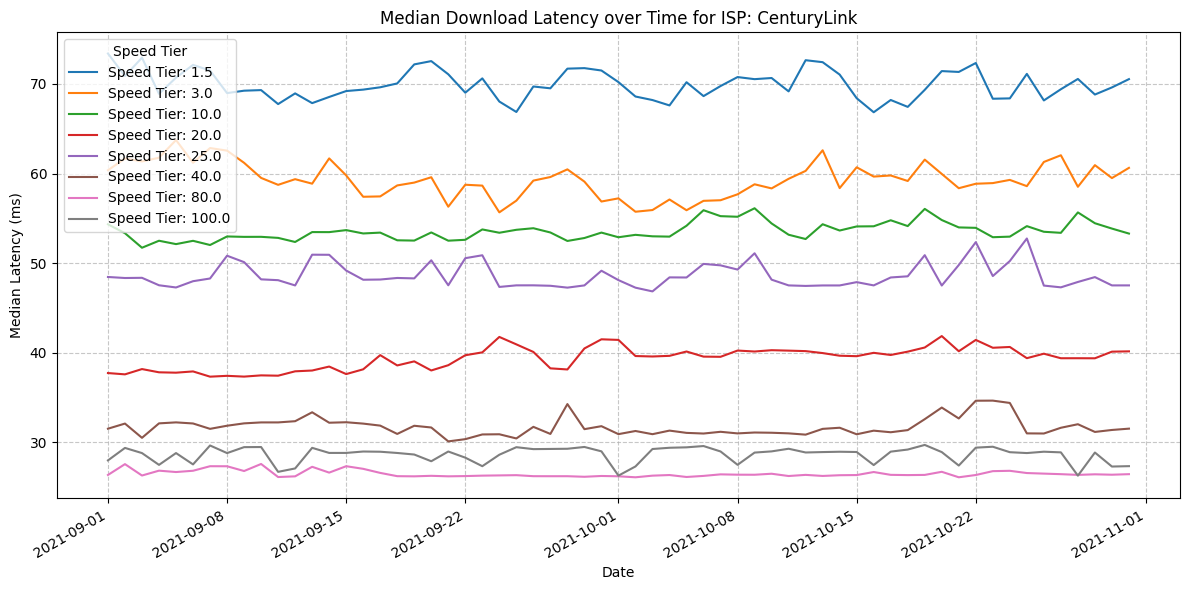

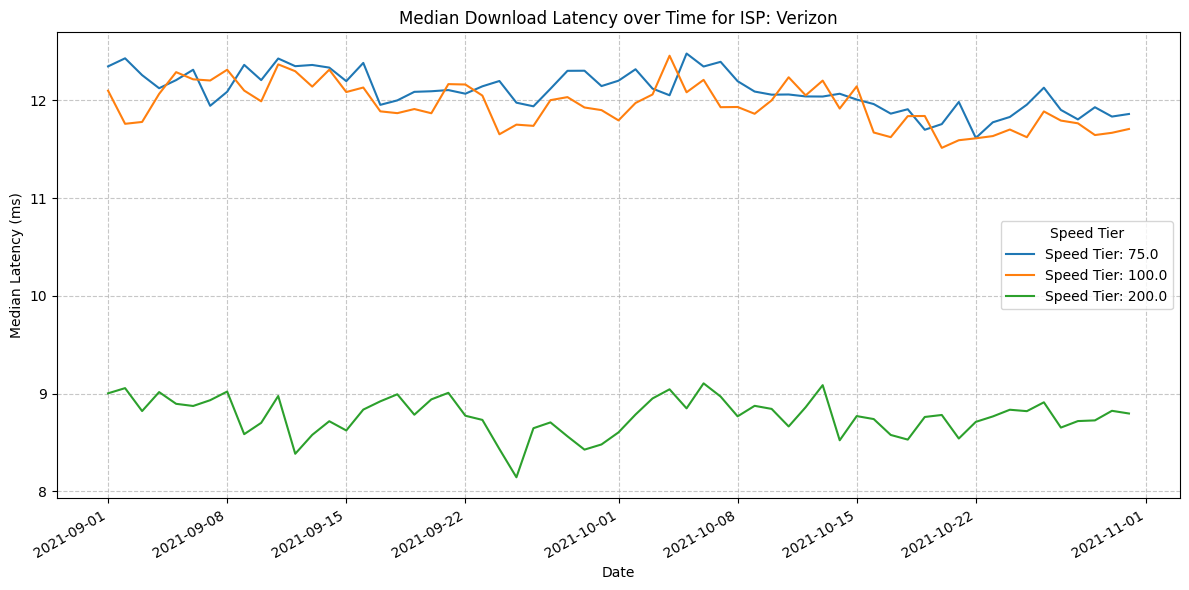

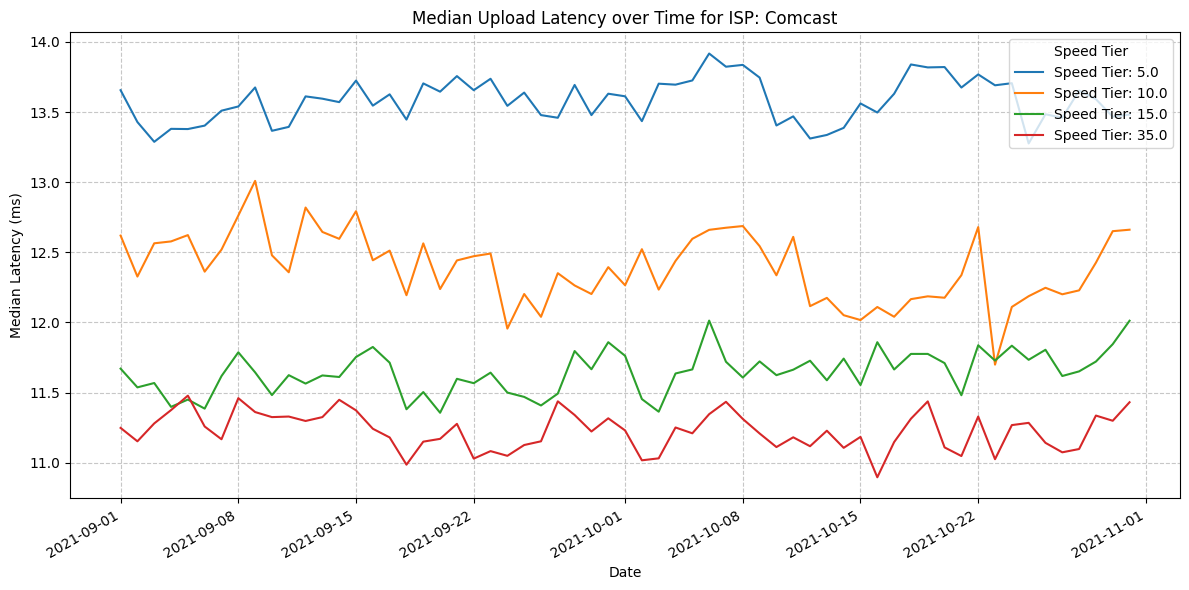

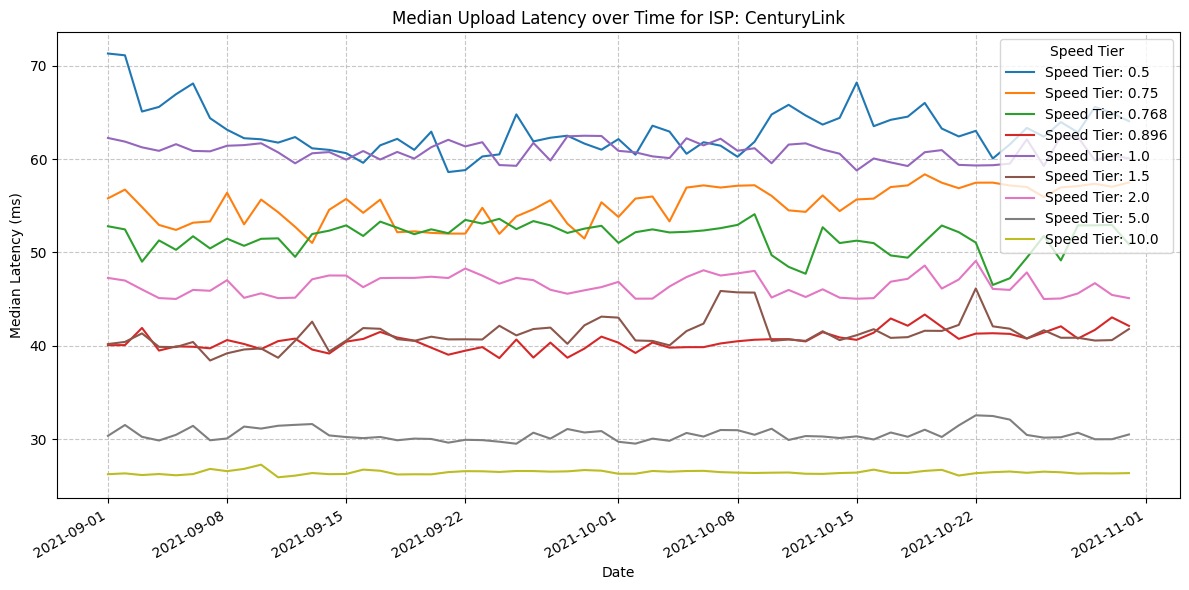

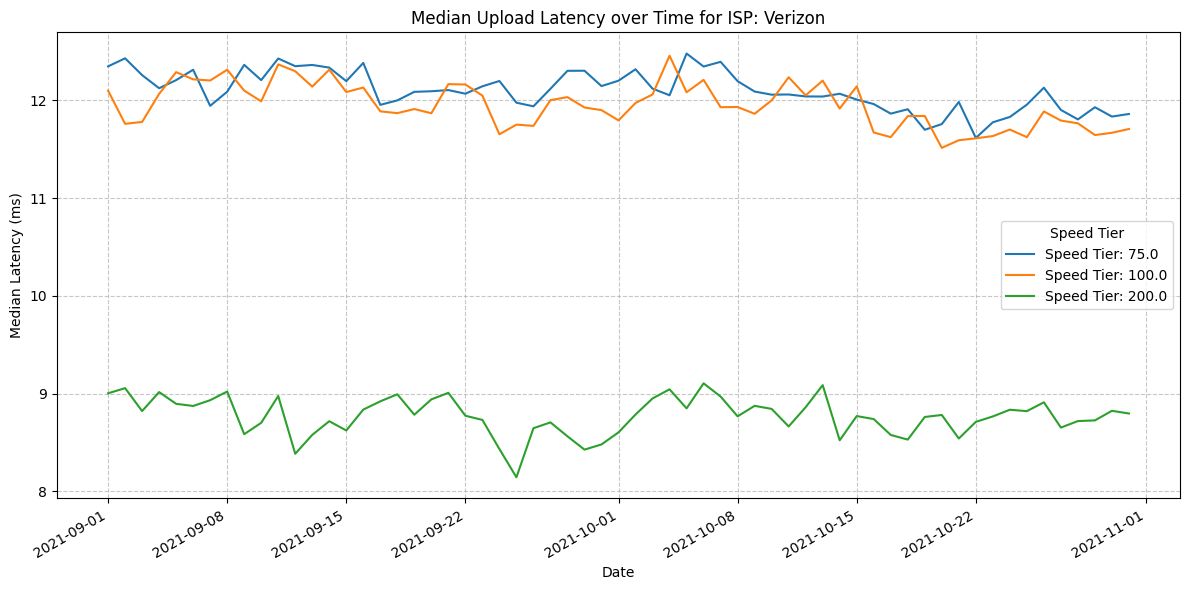

In [14]:
plot_data(agg_download_data, 'download')
plot_data(agg_upload_data, 'upload')